In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-06-23 12:47:06.564692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 12:47:06.705408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 12:47:06.754254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8463] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 12:47:06.768884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 12:47:06.824232: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def X_true(x):
    return x**2

def Y(y):
    return 0.1 / (y**2 + (0.05)**2)

def f(x, y):
    return X_true(x) * Y(y)

In [3]:
# Fix a seed:
np.random.seed(45)

# Fix number of points:
number_of_points = 1000

# Geerate random "input data":
x_data = np.random.uniform(0, 1, number_of_points).astype(np.float32)
y_data = np.random.uniform(0, 1, number_of_points).astype(np.float32)

x_mean, x_stddev = np.mean(x_data), np.std(x_data)
y_mean, y_stddev = np.mean(y_data), np.std(y_data)

normalized_x_inputs = (x_data - x_mean) / x_stddev
normalized_y_inputs = (y_data - y_mean) / y_stddev

# Evaluate the function with the input data:
f_data = f(x_data, y_data).astype(np.float32)

# True values, without normalization:
true_X_values = X_true(x_data)
true_Y_values = Y(y_data)
true_f_values = true_X_values * true_Y_values

# Normalizing:
function_X_mean, function_X_stddev = np.mean(true_X_values), np.std(true_X_values)
function_Y_mean, function_Y_stddev = np.mean(true_Y_values), np.std(true_Y_values)

normalized_X_values = (true_X_values - function_X_mean) / function_X_stddev
normalized_Y_values = (true_Y_values - function_Y_mean) / function_Y_stddev

normalized_f_data = normalized_X_values * normalized_Y_values

Visualize the *input data*!

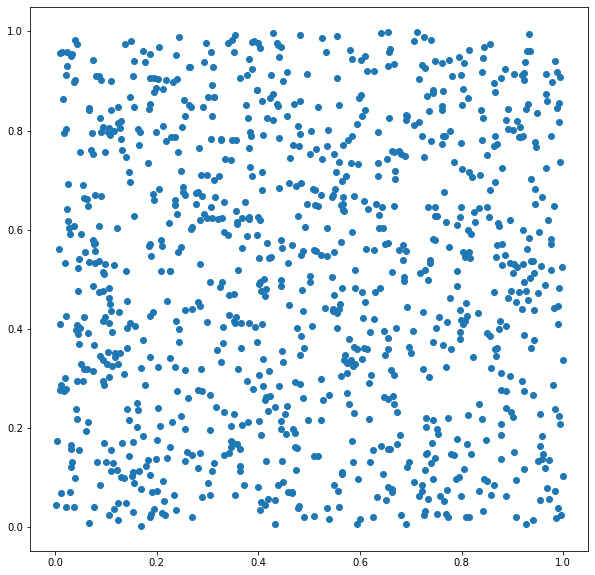

In [4]:
a = plt.figure(figsize = (10, 10))
a_axis = a.add_subplot(1, 1, 1)
a_axis.scatter(x_data, y_data)

Visualize the *function* data.

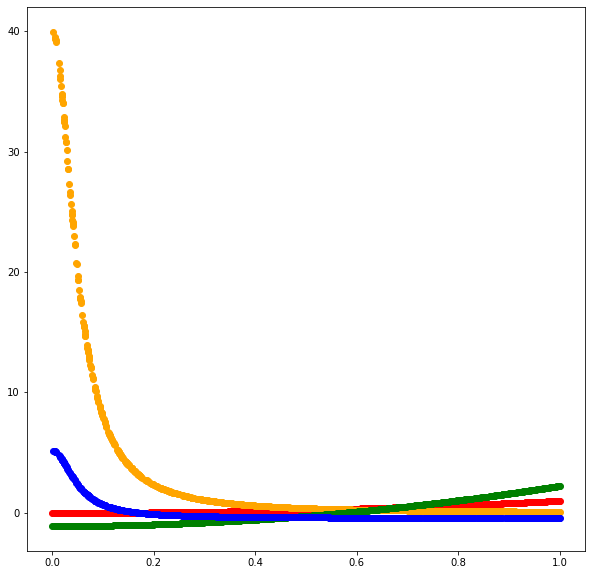

In [5]:
a = plt.figure(figsize = (10, 10))
a_axis = a.add_subplot(1, 1, 1)

a_axis.scatter(x_data, X_true(x_data), color = "red", label = "Non-normalized X")
a_axis.scatter(y_data, Y(y_data), color = "orange", label = "Non-normalized Y")

a_axis.scatter(x_data, normalized_X_values, color = "green", label = "Normalized X")
a_axis.scatter(y_data, normalized_Y_values, color = "blue", label = "Normalized Y")

plt.legend()

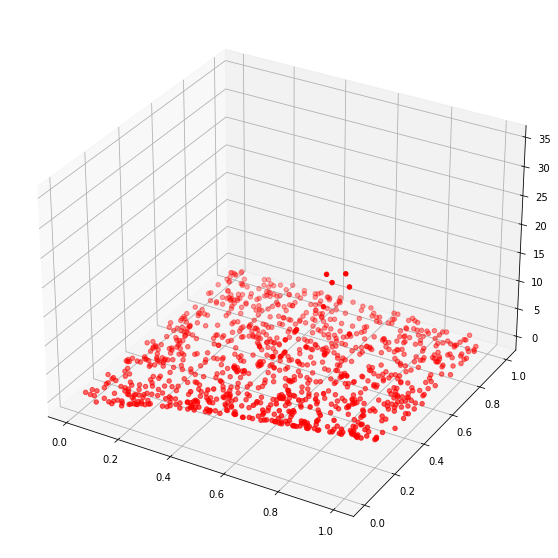

In [6]:
b = plt.figure(figsize = (18, 10))
b_axis = b.add_subplot(1, 1, 1, projection = "3d")
b_axis.scatter(x_data, y_data, f_data, color = 'red')

In [7]:
# 3. Build TF Dataset
dataset = tf.data.Dataset.from_tensor_slices((
    (normalized_x_inputs, normalized_y_inputs), normalized_f_data))
dataset = dataset.shuffle(buffer_size = 1024).batch(32)

I0000 00:00:1750700832.979586 1420813 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750700833.013166 1420813 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750700833.013312 1420813 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1750700833.015623 1420813 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
# 4. Define the model for X(x) only
inputs_x = tf.keras.Input(shape=(1,))
x_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])

Xx_output = x_model(inputs_x)

# Wrap it in a Model for training with custom loss
model = tf.keras.Model(inputs = inputs_x, outputs = Xx_output)

# 5. Define custom loss: f_pred = NN(x) * Y(y)
@tf.function
def custom_loss(y_true, x_pred, y_input):
    y_input = tf.cast(y_input, tf.float32)
    y_factor = 0.1 / (y_input**2 + 0.05**2)
    f_pred = tf.squeeze(x_pred) * y_factor
    return tf.reduce_mean(tf.square(f_pred - y_true))


In [9]:
# 6. Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_history = []

for epoch in range(500):
    epoch_loss = 0
    for (x_batch, y_batch), f_batch in dataset:
        with tf.GradientTape() as tape:
            x_pred = model(x_batch, training=True)
            loss = custom_loss(f_batch, x_pred, y_batch)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        epoch_loss += loss.numpy()
    loss_history.append(epoch_loss / len(dataset))
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss_history[-1]:.4f}")

2025-06-23 12:47:14.981219: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0: Loss = 5.5590


2025-06-23 12:47:15.603421: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-23 12:47:16.869928: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-23 12:47:19.284710: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-23 12:47:24.037927: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Loss = 1.0978


2025-06-23 12:47:35.074385: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40: Loss = 1.0625
Epoch 60: Loss = 1.1615


2025-06-23 12:47:56.552088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 80: Loss = 1.0838
Epoch 100: Loss = 1.1063
Epoch 120: Loss = 1.0548


2025-06-23 12:48:39.935433: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 140: Loss = 1.0975
Epoch 160: Loss = 1.0552
Epoch 180: Loss = 1.0648
Epoch 200: Loss = 1.0730
Epoch 220: Loss = 1.1289
Epoch 240: Loss = 4.4378


2025-06-23 12:50:02.319421: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260: Loss = 1.0685
Epoch 280: Loss = 1.0659
Epoch 300: Loss = 5.5619
Epoch 320: Loss = 1.1407
Epoch 340: Loss = 1.1414
Epoch 360: Loss = 1.0910
Epoch 380: Loss = 1.0870
Epoch 400: Loss = 1.4720
Epoch 420: Loss = 8.0447
Epoch 440: Loss = 3.1232
Epoch 460: Loss = 2.0186
Epoch 480: Loss = 1.6958


I0000 00:00:1750701170.695468 1420907 service.cc:146] XLA service 0x7c6f6c006ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750701170.695507 1420907 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-06-23 12:52:50.700741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-23 12:52:50.714989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/7 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step

I0000 00:00:1750701171.200324 1420907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


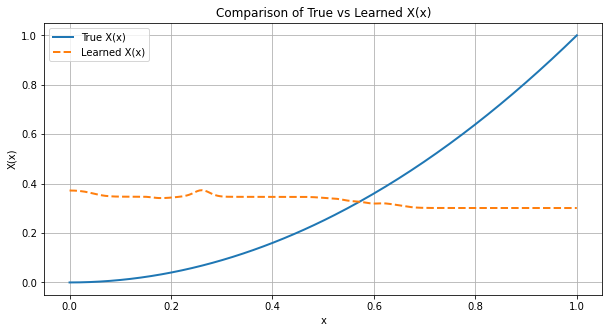

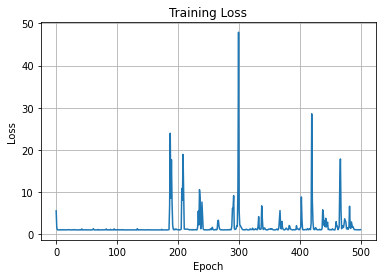

In [10]:
# 7. Visualization
x_plot = np.linspace(0, 1, 200)
x_plot_norm = (x_plot - x_mean) / x_stddev
x_pred_normalized = model.predict(x_plot_norm)
x_pred = x_pred_normalized * function_X_stddev + function_X_mean

x_true = X_true(x_plot)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, x_true, label="True X(x)", linewidth=2)
plt.plot(x_plot, x_pred, '--', label="Learned X(x)", linewidth=2)
plt.title("Comparison of True vs Learned X(x)")
plt.xlabel("x")
plt.ylabel("X(x)")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curve
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Epoch 0: Train Loss = 3.1161e+03, Val Loss = 1.2597e+03


2025-06-23 12:53:03.231641: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Train Loss = 3.5050e+02, Val Loss = 5.8755e+02
Epoch 40: Train Loss = 3.7098e+02, Val Loss = 1.4206e+02
Epoch 60: Train Loss = 6.9511e+01, Val Loss = 8.9046e+01
Epoch 80: Train Loss = 3.3924e+02, Val Loss = 6.5359e+02
Epoch 100: Train Loss = 6.6050e+02, Val Loss = 6.9597e+02
Epoch 120: Train Loss = 3.4680e+02, Val Loss = 2.9794e+02
Epoch 140: Train Loss = 4.3411e+02, Val Loss = 4.2312e+02
Epoch 160: Train Loss = 5.6365e+02, Val Loss = 6.1977e+02
Epoch 180: Train Loss = 5.0810e+02, Val Loss = 7.3223e+02
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


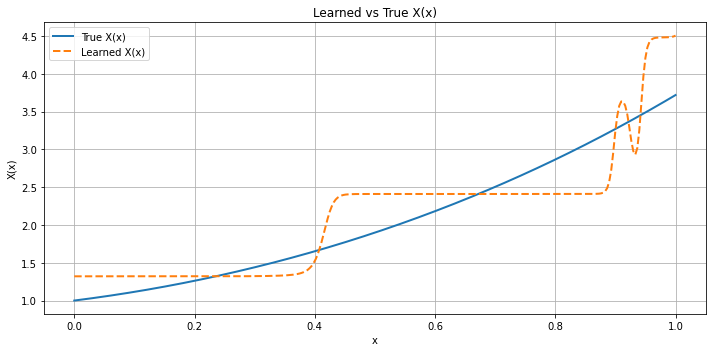

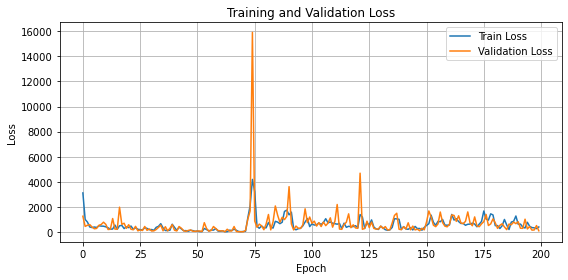

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. True functions
# -----------------------------
def X_true(x):
    return x**2 + np.exp(x)

def Y(y):
    return 1 / (y**2 + 0.05**2)

def f(x, y):
    return X_true(x) * Y(y)

# -----------------------------
# 2. Generate data
# -----------------------------
np.random.seed(42)
num_points = 5000
x_data = np.random.uniform(-2, 2, num_points).astype(np.float32)
y_data = np.random.uniform(-2, 2, num_points).astype(np.float32)

# True outputs
X_vals = X_true(x_data)
Y_vals = Y(y_data)
f_vals = X_vals * Y_vals

# Normalize x and X(x)
x_mean, x_std = np.mean(x_data), np.std(x_data)
x_norm = (x_data - x_mean) / x_std

X_mean, X_std = np.mean(X_vals), np.std(X_vals)
X_norm = (X_vals - X_mean) / X_std

# Training target: f(x, y) = normalized X(x) * Y(y)
f_data = X_norm * Y_vals

# -----------------------------
# 3. Train-validation split
# -----------------------------
x_train, x_val, y_train, y_val, f_train, f_val = train_test_split(
    x_norm, y_data, f_data, test_size=0.2, random_state=1
)

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), f_train)).shuffle(1024).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), f_val)).batch(64)

# -----------------------------
# 4. Model for X(x)
# -----------------------------
x_input = Input(shape=(1,))
x = Dense(64, activation='tanh')(x_input)
x = Dense(64, activation='tanh')(x)
x = Dense(64, activation='tanh')(x)
x_output = Dense(1)(x)

model = Model(inputs=x_input, outputs=x_output)

# -----------------------------
# 5. Custom loss
# -----------------------------
@tf.function
def custom_loss(y_true, x_pred, y_input):
    y_input = tf.cast(y_input, tf.float32)
    y_factor = 1 / (y_input**2 + 0.05**2)
    f_pred = tf.squeeze(x_pred) * y_factor
    return tf.reduce_mean(tf.square(f_pred - y_true))

# -----------------------------
# 6. Training loop
# -----------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss_history = []
val_loss_history = []

for epoch in range(200):
    train_loss = 0
    for (x_batch, y_batch), f_batch in train_dataset:
        with tf.GradientTape() as tape:
            x_pred = model(x_batch, training=True)
            loss = custom_loss(f_batch, x_pred, y_batch)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_loss += loss.numpy()
    train_loss /= len(train_dataset)
    train_loss_history.append(train_loss)

    val_loss = 0
    for (x_batch, y_batch), f_batch in val_dataset:
        x_pred = model(x_batch, training=False)
        loss = custom_loss(f_batch, x_pred, y_batch)
        val_loss += loss.numpy()
    val_loss /= len(val_dataset)
    val_loss_history.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4e}, Val Loss = {val_loss:.4e}")

# -----------------------------
# 7. Evaluate learned X(x)
# -----------------------------
x_vis = np.linspace(0, 1, 300).astype(np.float32)
x_vis_norm = (x_vis - x_mean) / x_std
x_pred_norm = model.predict(x_vis_norm)
x_pred = x_pred_norm * X_std + X_mean
x_true = X_true(x_vis)

plt.figure(figsize=(10, 5))
plt.plot(x_vis, x_true, label='True X(x)', linewidth=2)
plt.plot(x_vis, x_pred, '--', label='Learned X(x)', linewidth=2)
plt.title("Learned vs True X(x)")
plt.xlabel("x")
plt.ylabel("X(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Loss curves
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 000: Train Loss = 2.5589e+00, Val Loss = 1.7252e-01
Epoch 020: Train Loss = 7.2280e-02, Val Loss = 8.2122e-02
Epoch 040: Train Loss = 6.7445e-02, Val Loss = 7.3256e-02
Epoch 060: Train Loss = 6.9978e-02, Val Loss = 8.2180e-02


2025-06-23 13:01:41.291912: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 080: Train Loss = 7.3332e-01, Val Loss = 2.3752e+00
Epoch 100: Train Loss = 7.5473e-02, Val Loss = 8.8900e-02
Epoch 120: Train Loss = 7.8934e-02, Val Loss = 7.6763e-02
Epoch 140: Train Loss = 7.7895e-02, Val Loss = 7.6897e-02
Epoch 160: Train Loss = 2.1790e-01, Val Loss = 2.2557e-01
Epoch 180: Train Loss = 2.2058e-01, Val Loss = 2.2613e-01
Epoch 200: Train Loss = 9.1275e-02, Val Loss = 8.8554e-02
Epoch 220: Train Loss = 8.3241e-02, Val Loss = 8.7819e-02
Epoch 240: Train Loss = 1.2499e-01, Val Loss = 1.2823e-01
Epoch 260: Train Loss = 9.0373e-02, Val Loss = 8.8202e-02
Epoch 280: Train Loss = 8.5260e-02, Val Loss = 1.0166e-01
Epoch 300: Train Loss = 8.1639e-02, Val Loss = 1.0204e-01
Epoch 320: Train Loss = 7.6377e-02, Val Loss = 7.8688e-02
Epoch 340: Train Loss = 1.3009e-01, Val Loss = 1.0591e-01
Epoch 360: Train Loss = 7.7390e-02, Val Loss = 1.0912e-01
Epoch 380: Train Loss = 2.2653e+00, Val Loss = 7.0753e+00
Epoch 400: Train Loss = 8.3024e-02, Val Loss = 9.0431e-02
Epoch 420: Tra

2025-06-23 13:25:30.678440: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 580: Train Loss = 1.6389e-01, Val Loss = 1.3703e-01
Epoch 600: Train Loss = 1.4585e-01, Val Loss = 1.8515e-01
Epoch 620: Train Loss = 4.9851e+00, Val Loss = 4.9968e+00
Epoch 640: Train Loss = 2.1819e-01, Val Loss = 1.2825e-01
Epoch 660: Train Loss = 3.3110e-01, Val Loss = 9.0406e-02
Epoch 680: Train Loss = 1.1158e-01, Val Loss = 1.1547e-01
Epoch 700: Train Loss = 4.3706e+00, Val Loss = 3.9211e+00
Epoch 720: Train Loss = 3.2033e+00, Val Loss = 5.0807e+00
Epoch 740: Train Loss = 2.3259e-01, Val Loss = 2.3030e-01
Epoch 760: Train Loss = 1.8939e+00, Val Loss = 1.6880e+00
Epoch 780: Train Loss = 1.5987e-01, Val Loss = 1.6246e-01
Epoch 800: Train Loss = 1.7030e-01, Val Loss = 3.7934e-01
Epoch 820: Train Loss = 1.5347e-01, Val Loss = 1.3719e-01
Epoch 840: Train Loss = 1.9773e-01, Val Loss = 2.7719e-01
Epoch 860: Train Loss = 2.9470e-01, Val Loss = 2.2604e-01
Epoch 880: Train Loss = 3.1200e-01, Val Loss = 1.2562e-01
Epoch 900: Train Loss = 1.8933e-01, Val Loss = 1.1819e-01
Epoch 920: Tra

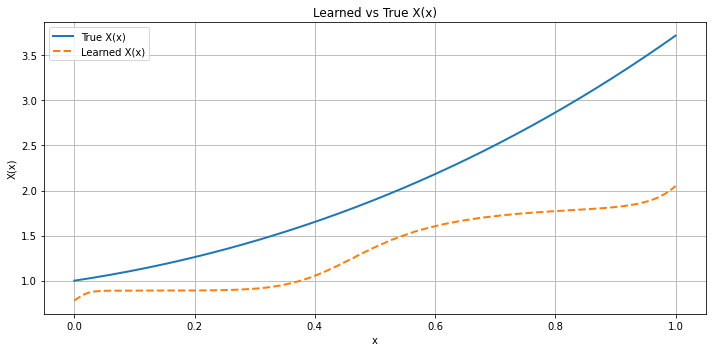

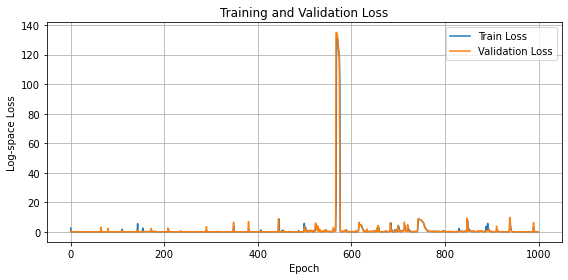

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Define true functions
# -----------------------------
def X_true(x):
    return x**2 + np.exp(x)

def Y(y):
    return 1 / (y**2 + 0.05**2)

def f(x, y):
    return X_true(x) * Y(y)

# -----------------------------
# 2. Generate and normalize data
# -----------------------------
np.random.seed(42)
num_points = 10000
x_data = np.random.uniform(-2, 2, num_points).astype(np.float32)
y_data = np.random.uniform(-2, 2, num_points).astype(np.float32)

X_vals = X_true(x_data)
Y_vals = Y(y_data)
f_vals = X_vals * Y_vals

# Normalize x
x_mean, x_std = np.mean(x_data), np.std(x_data)
x_norm = (x_data - x_mean) / x_std

# Normalize y
y_mean, y_std = np.mean(y_data), np.std(y_data)
y_norm = (y_data - y_mean) / y_std

# Normalize X(x)
X_mean, X_std = np.mean(X_vals), np.std(X_vals)
X_norm = (X_vals - X_mean) / X_std

# Normalize Y(y)
Y_mean, Y_std = np.mean(Y_vals), np.std(Y_vals)
Y_norm = (Y_vals - Y_mean) / Y_std

# For training, we'll normalize f as well
f_mean, f_std = np.mean(f_vals), np.std(f_vals)
f_norm = (f_vals - f_mean) / f_std

# -----------------------------
# 3. Train-validation split
# -----------------------------
# x_train, x_val, y_train, y_val, f_train, f_val = train_test_split(
#     x_norm, y_data, f_norm, test_size=0.2, random_state=1
# )

x_train, x_val, y_train, y_val, f_train, f_val = train_test_split(
    x_norm, y_norm, f_norm, test_size = 0.2, random_state=1
)

train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), f_train)).shuffle(1024).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), f_val)).batch(64)

# -----------------------------
# 4. Neural network to model X(x)
# -----------------------------
x_input = Input(shape=(1,))
x = Dense(64, activation='tanh')(x_input)
x = Dense(64, activation='tanh')(x)
x = Dense(64, activation='tanh')(x)
x_output = Dense(1)(x)

model = Model(inputs=x_input, outputs=x_output)

# -----------------------------
# 5. Stable custom log-based loss
# -----------------------------
@tf.function
def custom_log_loss(y_true_norm, x_pred, y_input):
    # Clip Y(y) to prevent explosion
    y_input = tf.cast(y_input, tf.float32)
    y_factor = 1 / (y_input**2 + 0.05**2)
    y_factor = tf.clip_by_value(y_factor, 1e-2, 1e2)

    # Unnormalize X(x) prediction
    x_pred = tf.squeeze(x_pred)
    X_pred = x_pred * X_std + X_mean

    # f_pred = X(x) * Y(y)
    f_pred = X_pred * y_factor
    f_pred = tf.maximum(f_pred, 1e-6)  # avoid log(0)

    # Unnormalize y_true
    f_true = y_true_norm * f_std + f_mean
    f_true = tf.maximum(f_true, 1e-6)

    return tf.reduce_mean(tf.square(tf.math.log(f_pred) - tf.math.log(f_true)))

# -----------------------------
# 6. Training loop
# -----------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss_history = []
val_loss_history = []

for epoch in range(1000):
    train_loss = 0
    for (x_batch, y_batch), f_batch in train_dataset:
        with tf.GradientTape() as tape:
            x_pred = model(x_batch, training=True)
            loss = custom_log_loss(f_batch, x_pred, y_batch)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_loss += loss.numpy()
    train_loss /= len(train_dataset)
    train_loss_history.append(train_loss)

    val_loss = 0
    for (x_batch, y_batch), f_batch in val_dataset:
        x_pred = model(x_batch, training=False)
        loss = custom_log_loss(f_batch, x_pred, y_batch)
        val_loss += loss.numpy()
    val_loss /= len(val_dataset)
    val_loss_history.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03}: Train Loss = {train_loss:.4e}, Val Loss = {val_loss:.4e}")

# -----------------------------
# 7. Visualize learned X(x)
# -----------------------------
x_vis = np.linspace(0, 1, 300).astype(np.float32)
x_vis_norm = (x_vis - x_mean) / x_std
x_pred_norm = model.predict(x_vis_norm).squeeze()
x_pred = x_pred_norm * X_std + X_mean

x_true = X_true(x_vis)

plt.figure(figsize=(10, 5))
plt.plot(x_vis, x_true, label='True X(x)', linewidth=2)
plt.plot(x_vis, x_pred, '--', label='Learned X(x)', linewidth=2)
plt.title("Learned vs True X(x)")
plt.xlabel("x")
plt.ylabel("X(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Visualize loss curves
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log-space Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
